Reference: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

# Purpose
研究客戶流失(churn)的相關議題

(1) 客戶離開組織的可能性有多大？ 
(2) 客戶流失的關鍵指標是什麼？ 
(3) 可以根據結果實施哪些保留策略以減少潛在客戶流失？

# 1. import data

In [1]:
# conda install -c anaconda py-xgboost

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1-1 Restart the session

In [3]:
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

## 1-2 Import relevant libraries

In [4]:
#Standard libraries for data analysis:  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, skew
from scipy import stats
import statsmodels.api as sm

import seaborn as sns # For creating plots
sns.set_style('darkgrid')

In [5]:
# sklearn modules for data preprocessing:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
#sklearn modules for Model Selection:
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
#sklearn modules for Model Evaluation & Improvement:   
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score

In [8]:
#Standard libraries for data visualization:
import seaborn as sn
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 
%matplotlib inline
color = sn.color_palette()

import matplotlib.ticker as mtick
from IPython.display import display
pd.options.display.max_columns = None
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve

In [9]:
#Miscellaneous Utilitiy Libraries:
import random
import os
import re
import sys
import timeit
import string
import time
from datetime import datetime
from time import time
from dateutil.parser import parse
import joblib

## 1-3 Read data:

In [10]:
dataset = pd.read_csv('customer_churn_data.csv')
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1-4 Evaluate data structure

0   customerID       
1   gender: 男性或女性            
2   SeniorCitizen: 客戶是否是老年人 (1, 0)     
3   Partner: 客戶是否有合作夥伴 (Yes, No)               
4   Dependents: 客戶是否有家屬 (Yes, No)      
5   tenure: 客戶停留的月數             
6   PhoneService: 客戶是否有電話服務 (Yes, No)      
7   MultipleLines: 客戶是否有多條線路 (Yes, No, No phone service)     
8   InternetService: 客戶的互聯網服務提供商 (DSL, Fiber optic, No)      
9   OnlineSecurity: 客戶是否有 online security (Yes, No, No internet service)    
10  OnlineBackup: 客戶是否有在線備份 (Yes, No, No internet service)       
11  DeviceProtection: 客戶是否有設備保護 (Yes, No, No internet service)       
12  TechSupport: 客戶是否有技術支持 (Yes, No, No internet service)       
13  StreamingTV: 客戶是否有 streaming TV (Yes, No, No internet service)       
14  StreamingMovies: 客戶是否有 streaming movies (Yes, No, No internet service)      
15  Contract: 客戶的合約期限 (Month-to-month, One year, Two year)         
16  PaperlessBilling: 客戶是否有無紙化計費 (Yes, No)      
17  PaymentMethod: 客戶的付款方式 (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))   
18  MonthlyCharges: 每月向客戶收取的金額     
19  TotalCharges: 向客戶收取的總金額   
20  Churn: 客戶是否流失 (Yes or No)        

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
dataset['SeniorCitizen'] = dataset['SeniorCitizen'].astype(object)
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### <span style="color:#3498DB">Point: 請就下列敘述性統計進行分析</span>

In [13]:
dataset.describe()  #建模前 要先做敘述型統計
# tenure 停留月數

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


客戶平均停留 32 個月，每月支付 64 美元，共支付2,283美元。 但是，不同客戶有不同的合約。

In [14]:
# 不同的合約期間，停留月數和付費情況是否有差異

dataset[['Contract','tenure', 'MonthlyCharges', 'TotalCharges']].groupby(['Contract'], as_index=True).mean()[['tenure', 'MonthlyCharges', 'TotalCharges']]

,tenure,MonthlyCharges,TotalCharges
Contract,,,
Month-to-month,18.036645,66.398490,1369.254581
One year,42.044807,65.048608,3034.683084
Two year,56.735103,60.770413,3728.933947


### <span style="color:#3498DB">Point: 請進一步分析你想看到的數據
* 如：不同性別&contract，人數是否有所差異？

In [15]:
dataset.pivot_table(index=['gender', 'Contract'], values='customerID', 
                    margins=True, aggfunc=['count'], margins_name= 'Total count')

count
                           customerID
gender      Contract                 
Female      Month-to-month       1925
            One year              718
            Two year              845
Male        Month-to-month       1950
            One year              755
            Two year              850
Total count                      7043

# 2. Data preprocessing

## 2-1 處理NA

In [16]:
dataset.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [17]:
#Removing missing values  #因為數量占得很少，直接刪掉
dataset.dropna(inplace = True)
#若要補值 : 找到那個人屬於方案後去依照方案平均去補值

## 2-2 清整數據並轉dummy variable

In [18]:
#Remove customer IDs from the data set
df = dataset.iloc[:,1:]

#Convertin the predictor variable in a binary numeric variable
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)

#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df)
df_dummies.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,True,False,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
1,34,56.95,1889.50,0,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True
2,2,53.85,108.15,1,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
3,45,42.30,1840.75,0,False,True,True,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False
4,2,70.70,151.65,1,True,False,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False


# 3. Descriptive statistics

## A. Demographics 

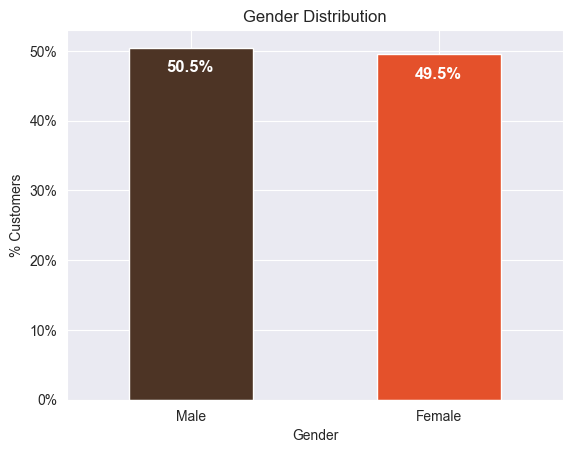

In [19]:
colors = ['#4D3425','#E4512B']
ax = (df['gender'].value_counts()*100.0 /len(df)).plot(kind='bar',stacked = True, rot = 0,color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers')
ax.set_xlabel('Gender')
ax.set_ylabel('% Customers')
ax.set_title('Gender Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold')
plt.show()

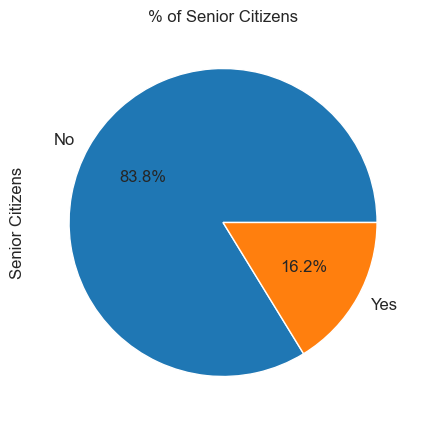

In [20]:
ax = (df['SeniorCitizen'].value_counts()*100.0 /len(df))\
.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)
plt.show()

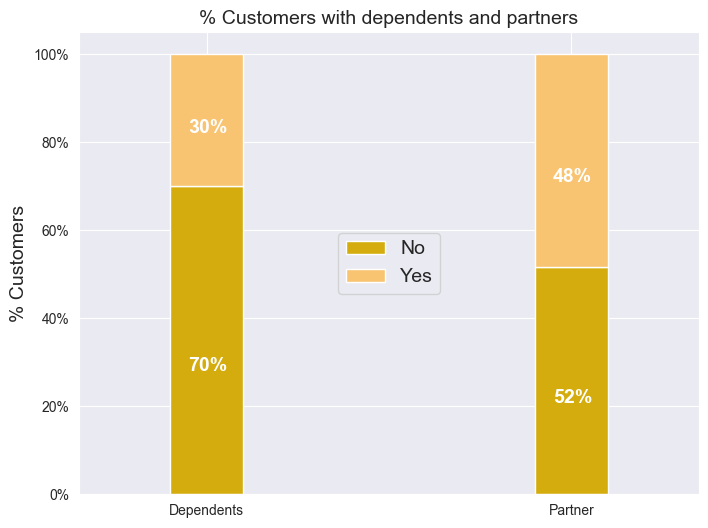

In [21]:
df2 = pd.melt(dataset, id_vars=['customerID'], value_vars=['Dependents','Partner'])
df3 = df2.groupby(['variable','value']).count().unstack()
df3 = df3*100/len(dataset)
colors = ['#D4AC0D','#F8C471']
ax = df3.loc[:,'customerID'].plot.bar(stacked=True, color=colors,
                                      figsize=(8,6),rot = 0,
                                     width = 0.2)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('')
ax.set_title('% Customers with dependents and partners',size = 14)
ax.legend(loc = 'center',prop={'size':14})

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
                weight = 'bold',
                size = 14)
    
# Dependents: 客戶是否有家屬 (Yes, No)  
# Partner: 客戶是否有合作夥伴 (Yes, No)               
plt.show()

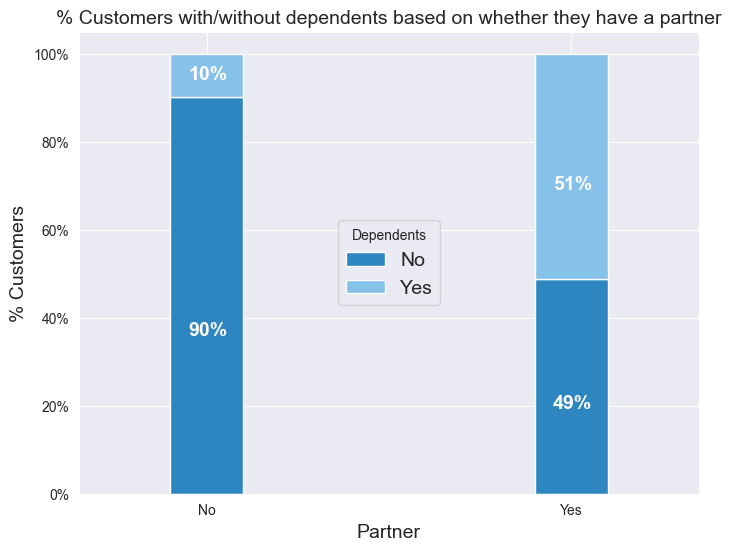

In [22]:
colors = ['#2E86C1','#85C1E9']
partner_dependents = dataset.groupby(['Partner','Dependents']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Dependents',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers with/without dependents based on whether they have a partner',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)
plt.show()

在有合作夥伴的客戶中，只有大約一半也有受撫養人，而另一半為單身。        
此外，在沒有合作夥伴的客戶中，大多數 (90%) 為單身。

## B. Customer Account Information:

### <span style="color:#3498DB">Question: 請說明客戶停留月數的情況 </span>

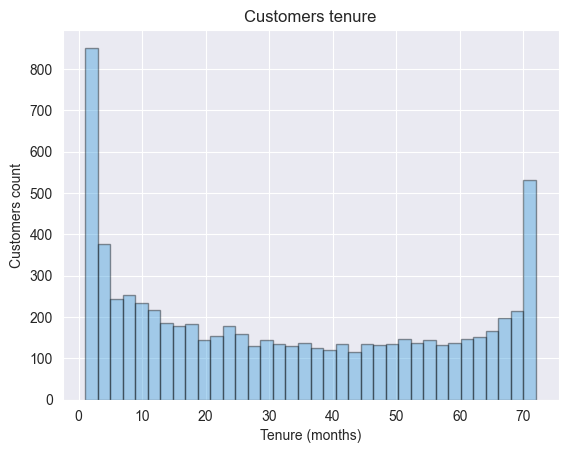

In [23]:
ax = sns.distplot(df['tenure'], 
                  hist=True, 
                  kde=False, 
                  bins=int(180/5), 
                  color = '#3498DB', 
                  hist_kws={'edgecolor':'black'},
                  kde_kws={'linewidth': 4})
ax.set_ylabel('Customers count')
ax.set_xlabel('Tenure (months)')
ax.set_title('Customers tenure')
plt.show()

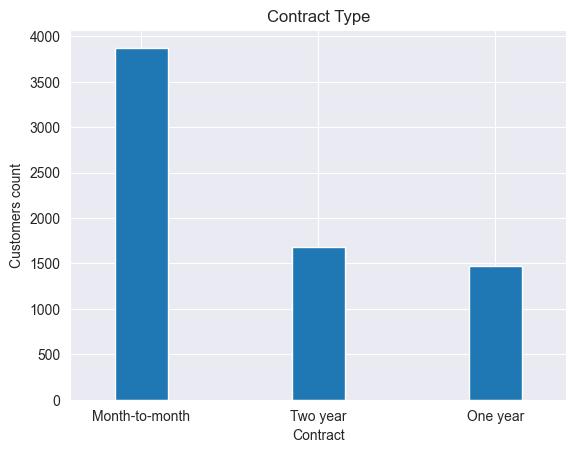

In [24]:
ax = df['Contract'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('Customers count')
ax.set_title('Contract Type')
plt.show()

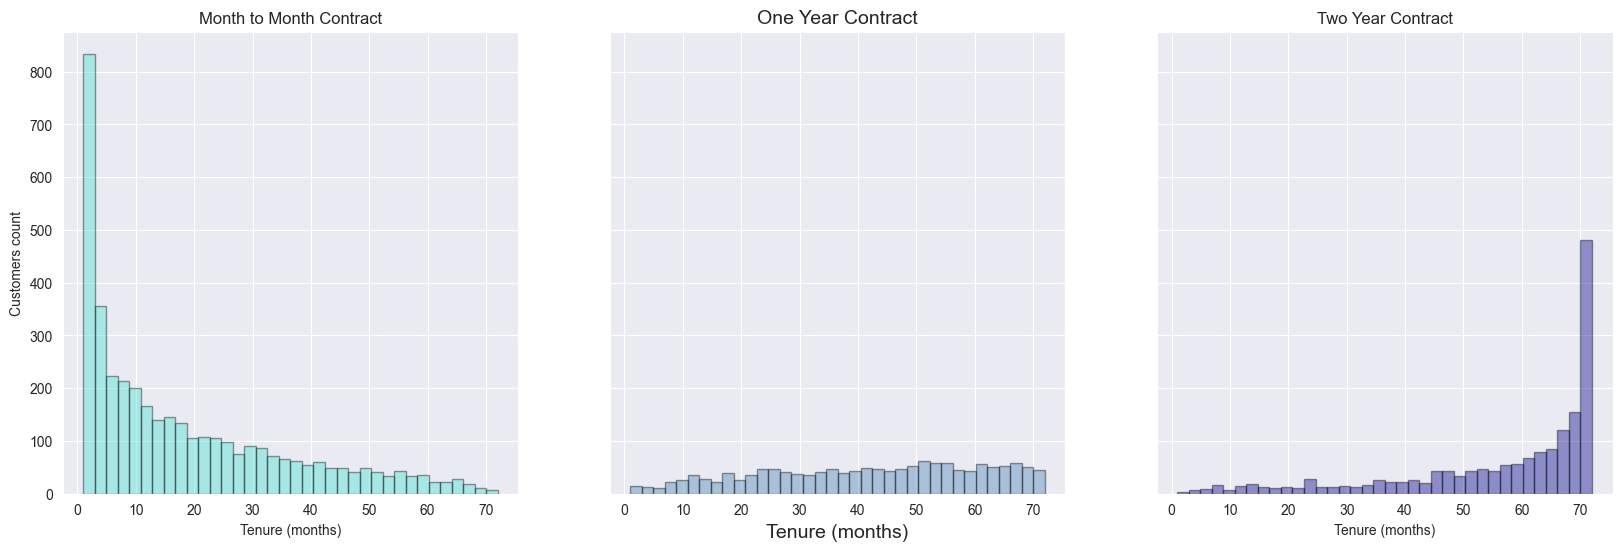

In [25]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(df[df['Contract']=='Month-to-month']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'turquoise',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('Customers count')
ax.set_xlabel('Tenure (months)')
ax.set_title('Month to Month Contract')

ax = sns.distplot(df[df['Contract']=='One year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'steelblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('One Year Contract',size = 14)

ax = sns.distplot(df[df['Contract']=='Two year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'darkblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract')
plt.show()

### <span style="color:#3498DB">Question: 請問上述三種合約期間有何特性？ 你會建議公司對合約期間有何種設定</span>

## C. Look at the distribution of various services used by customers

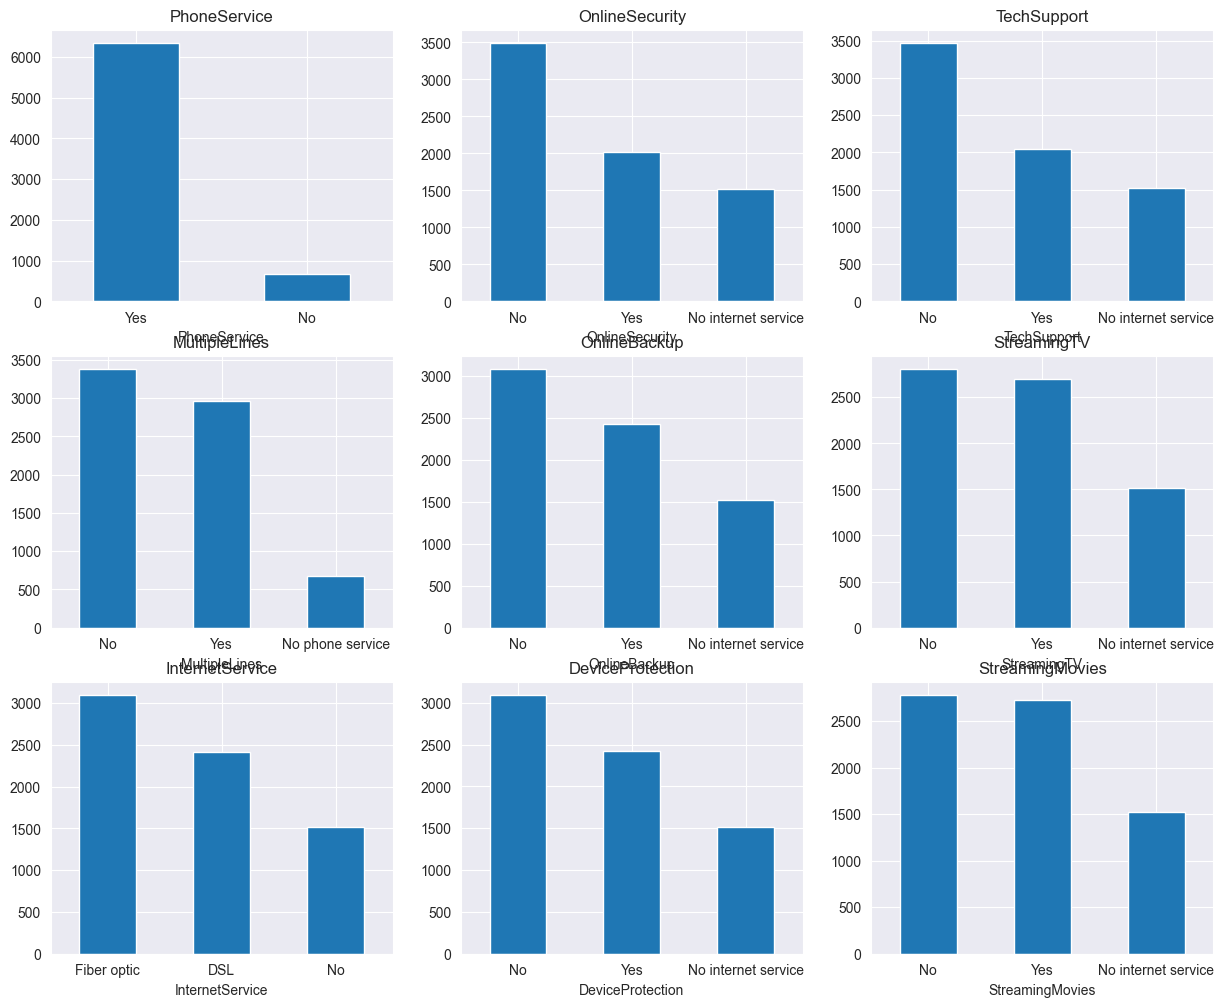

In [26]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services):
    if i < 3:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)
plt.show()

### <span style="color:#3498DB">Question: 請問瀏覽上述客戶所接受的各種服務，你有什麼想法</span>

## D. Look at 'Churn' and understand its interaction with other important variables

In [27]:
P = dataset.groupby('Churn')['customerID'].count().reset_index()
P['Percentage'] = 100 * P['customerID']  / P['customerID'].sum()
P

,Churn,customerID,Percentage
0,No,5163,73.421502
1,Yes,1869,26.578498


### D-1 Churn vs Tenure:

### <span style="color:#3498DB">Question: 請問在多久的tenure客戶，churn的可能性較高？</span>

<Axes: xlabel='Churn', ylabel='tenure'>

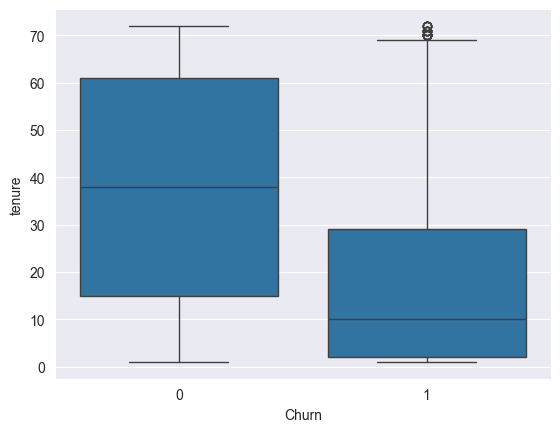

In [28]:
sns.boxplot(x = df.Churn, y = df.tenure)

### D-2 Churn by Contract Type

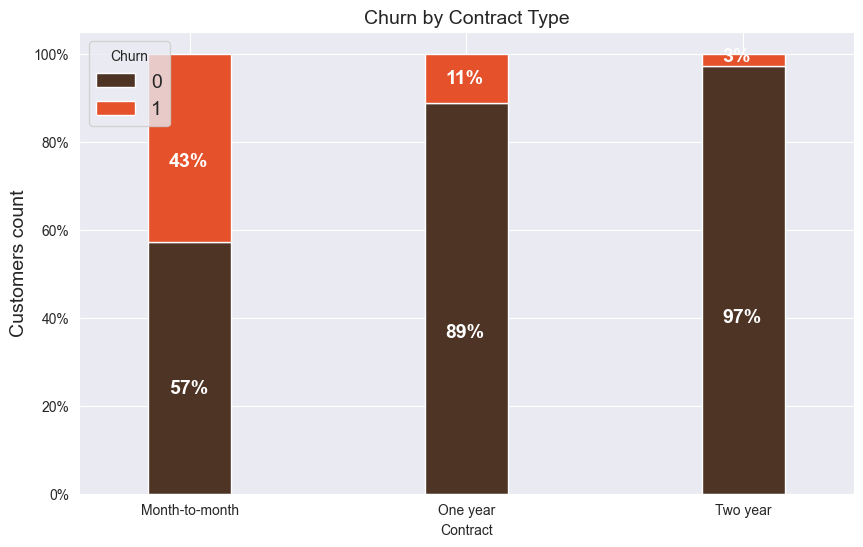

In [29]:
colors = ['#4D3425','#E4512B']
contract_churn = df.groupby(['Contract','Churn']).size().unstack()
ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar', width = 0.3, stacked = True,
                                      rot = 0, figsize = (10,6), color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('Customers count',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
                weight = 'bold',
                size = 14)
plt.show()

### D-3 Churn by Seniority

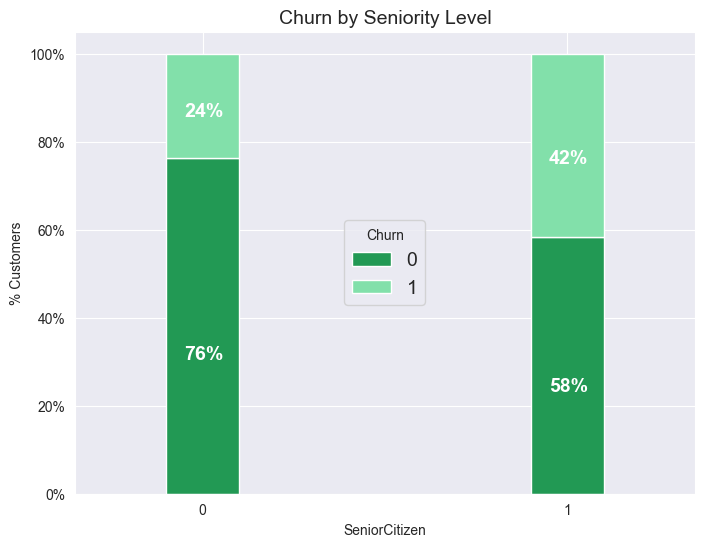

In [30]:
colors = ['#229954','#82E0AA']
seniority_churn = df.groupby(['SeniorCitizen','Churn']).size().unstack()

ax = (seniority_churn.T*100.0 / seniority_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers')
ax.set_title('Churn by Seniority Level',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',size =14)
plt.show()

### D-4 Churn by Monthly Charges

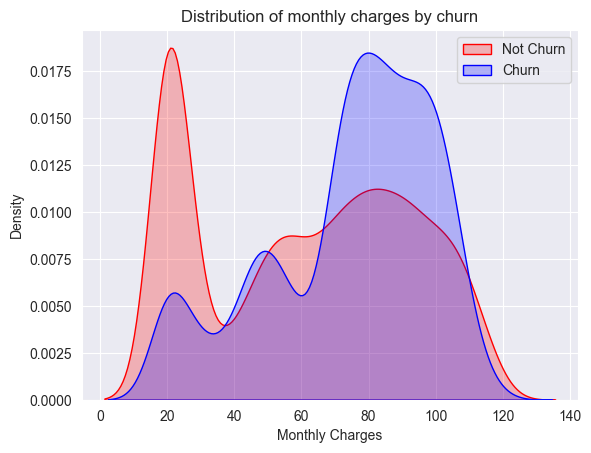

In [31]:
ax = sns.kdeplot(dataset.MonthlyCharges[(dataset["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(dataset.MonthlyCharges[(dataset["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')
plt.show()

### D-5 Churn by Total Charges

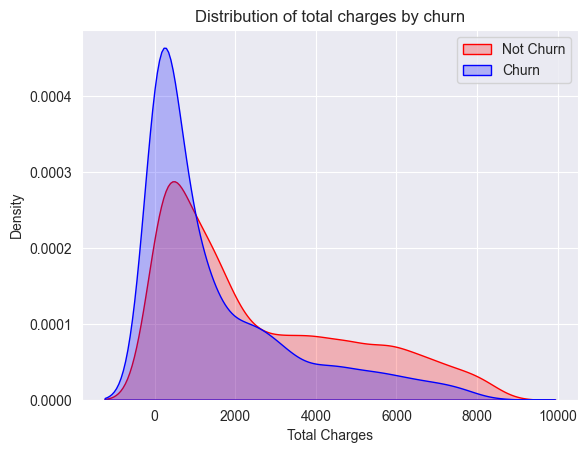

In [32]:
ax = sns.kdeplot(dataset.TotalCharges[(dataset["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(dataset.TotalCharges[(dataset["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')
plt.show()

# 3. Modeling

In [33]:
df_dummies.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,True,False,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
1,34,56.95,1889.50,0,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True
2,2,53.85,108.15,1,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
3,45,42.30,1840.75,0,False,True,True,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False
4,2,70.70,151.65,1,True,False,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False


In [34]:
# We will use the data frame where we had created dummy variables
X = df_dummies.drop(columns = ['Churn'])
y = df_dummies['Churn'].values

# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

In [35]:
# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
#數據量比較少 80% 數量夠多 70% (train)

## 3-1 Logistic Regression (PPT 2.1)

In [36]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression()
result = model_log.fit(X_train, y_train)

In [37]:
from sklearn import metrics
y_test_pred_log = model_log.predict(X_test)

print (metrics.accuracy_score(y_test, y_test_pred_log))

0.8137882018479033


In [38]:
model_log.predict_proba(X_test)

array([[0.36691012, 0.63308988],
       [0.83568389, 0.16431611],
       [0.72336517, 0.27663483],
       ...,
       [0.94130745, 0.05869255],
       [0.95234239, 0.04765761],
       [0.98380158, 0.01619842]], shape=(1407, 2))

In [39]:
y_test_pred_log #預設0.5

array([1, 0, 0, ..., 0, 0, 0], shape=(1407,))

Text(0.5, 23.52222222222222, 'Predicted label\n')

<Figure size 2800x2000 with 0 Axes>

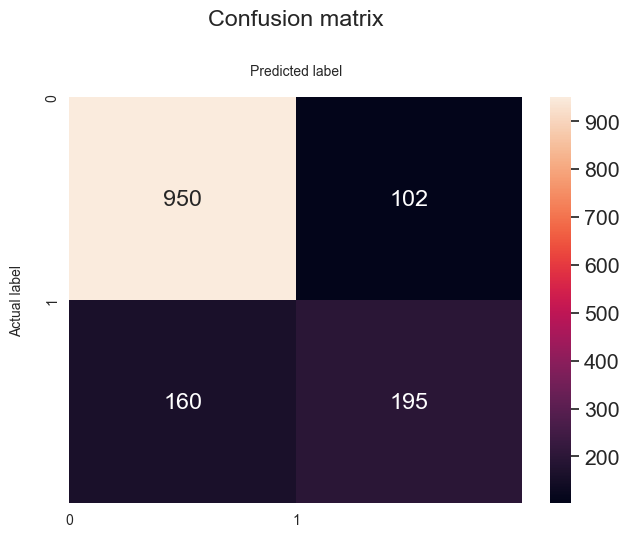

In [40]:
# Create the Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_log) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))

fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')

class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

In [41]:
# TP=196, FP=102, FN=159, TN=950

print(f'Accuracy : {round((196+950)/(196+102+950+159),3)}')    # (TP + TN) / (TP + FP + TN + FN) 
print(f'Precision : {round((196)/(196+102), 3)}')              # TP / (TP + FP)
print(f'Recall/Sensitivity : {round((196)/(196+159), 3)}')     # TP / (TP + FN)
print(f'Specificity : {round((950)/(950+102), 3)}')            # TN / (TN + FP)

Accuracy : 0.814
Precision : 0.658
Recall/Sensitivity : 0.552
Specificity : 0.903


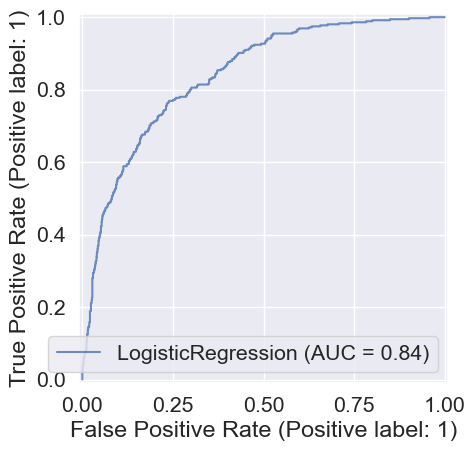

In [42]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
log_disp = RocCurveDisplay.from_estimator(model_log, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

### <span style="color:#3498DB">Question: 什麼樣的因素與churn呈現明顯的正向影響與負向影響 </span>

Axes(0.125,0.11;0.775x0.77)


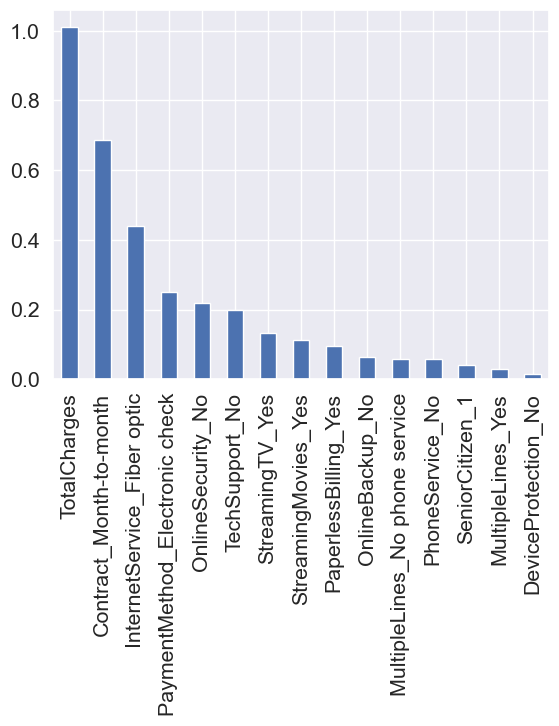

In [43]:
# To get the weights of all the variables
weights = pd.Series(model_log.coef_[0], index=X.columns.values)
print (weights.sort_values(ascending = False)[:15].plot(kind='bar'))

* TotalCharges越高的，流失機會越大
* 擁有1個月的合約期會增加流失流失的機會

Axes(0.125,0.11;0.775x0.77)


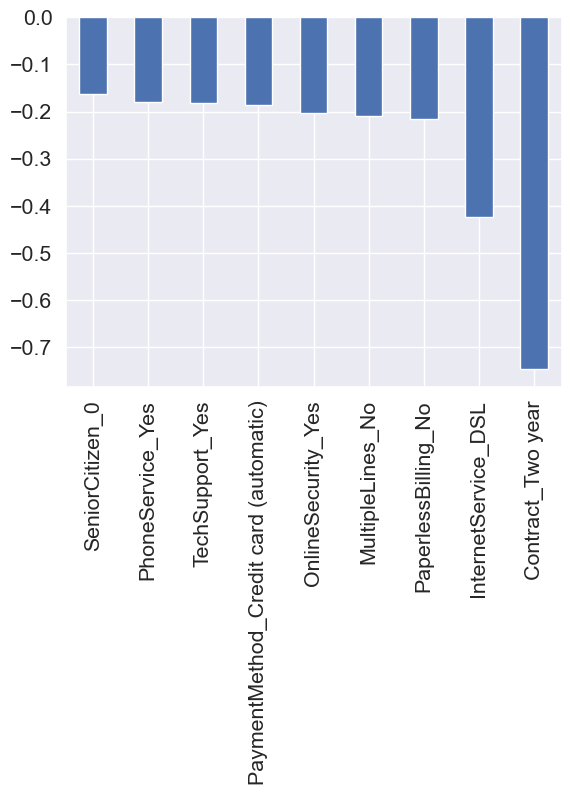

In [44]:
print(weights.sort_values(ascending = False)[-10:-1].plot(kind='bar'))

* 兩年的合約會減少流失率
* 擁有 InternetService DSL的客戶，流失率也會降低

## 3-2 Support Vecor Machine (SVM) (PPT 2.2)

In [45]:
from sklearn.svm import SVC

model_svm = SVC(kernel='rbf') 
model_svm.fit(X_train,y_train)
y_test_pred_svm = model_svm.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred_svm)

0.8088130774697939

Text(0.5, 15.049999999999999, 'Predicted label\n')

<Figure size 2800x2000 with 0 Axes>

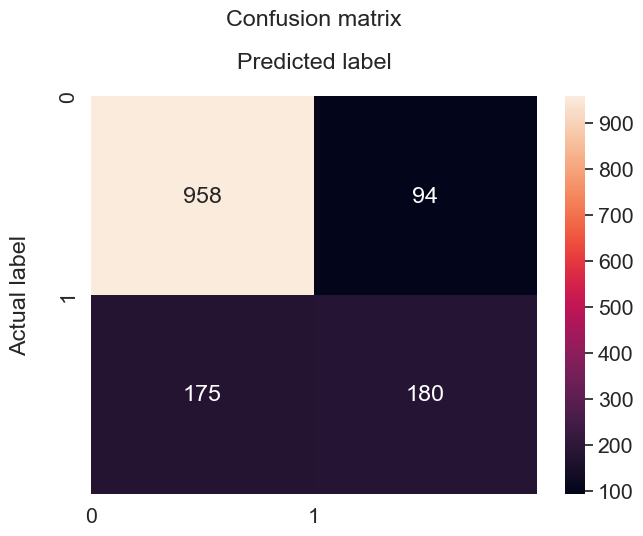

In [46]:
# Create the Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_svm) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))

fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')

class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

In [47]:
# TP=180, FP=94, FN=175, TN=958

print(f'Accuracy : {round((180+958)/(180+94+958+175),3)}')    # (TP + TN) / (TP + FP + TN + FN) 
print(f'Precision : {round((180)/(180+94), 3)}')              # TP / (TP + FP)
print(f'Recall/Sensitivity : {round((180)/(180+175), 3)}')     # TP / (TP + FN)
print(f'Specificity : {round((958)/(958+94), 3)}')            # TN / (TN + FP)

Accuracy : 0.809
Precision : 0.657
Recall/Sensitivity : 0.507
Specificity : 0.911


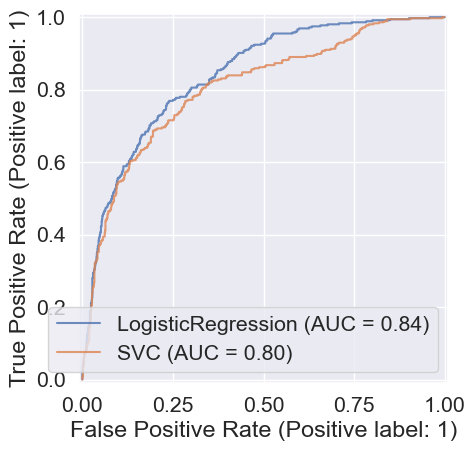

In [48]:
ax = plt.gca()
log_disp = RocCurveDisplay.from_estimator(model_log, X_test, y_test, ax=ax, alpha=0.8)
svm_disp = RocCurveDisplay.from_estimator(model_svm, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

In [55]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

preprocessor = make_pipeline(SelectKBest(f_classif, k=10))  # 僅保留好的K個變數
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0)) #random_state固定預測結果

In [56]:
SVM.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'pipeline', 'standardscaler', 'svc', 'pipeline__memory', 'pipeline__steps', 'pipeline__transform_input', 'pipeline__verbose', 'pipeline__selectkbest', 'pipeline__selectkbest__k', 'pipeline__selectkbest__score_func', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [64]:
hyper_params_svm = {'svc__gamma':[0.001, 0.0001, 0.0005,0.00025], 'svc__C':[1, 5,10, 100, 1000, 3000,5000],}

In [65]:
grid_svm = GridSearchCV(SVM, hyper_params_svm,scoring='recall', cv=3) # GridSearchCV:網格搜索, cv:交叉驗證
grid_svm.fit(X_train, y_train)

print(grid_svm.best_params_)

{'svc__C': 5, 'svc__gamma': 0.00025}


In [66]:
y_test_pred_gridsvm = grid_svm.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred_gridsvm)

0.8031272210376688

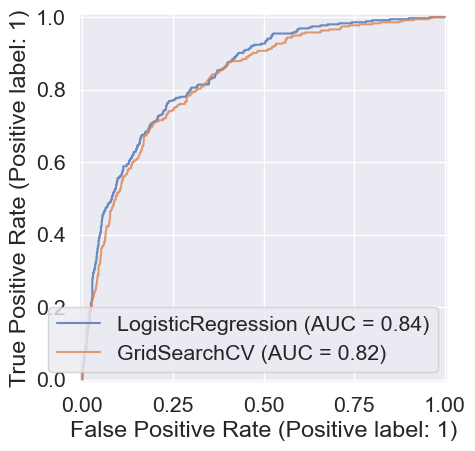

In [67]:
ax = plt.gca()
log_disp = RocCurveDisplay.from_estimator(model_log, X_test, y_test, ax=ax, alpha=0.8)
grid_svm_disp = RocCurveDisplay.from_estimator(grid_svm, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

## 3-3  Decision Tree (PPT 2.3)

In [68]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(criterion = 'gini')  # CART, 默認為gini
clf = model_dt.fit(X_train, y_train)

# Make predictions
y_test_pred_dt = model_dt.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_pred_dt))

0.7235252309879175


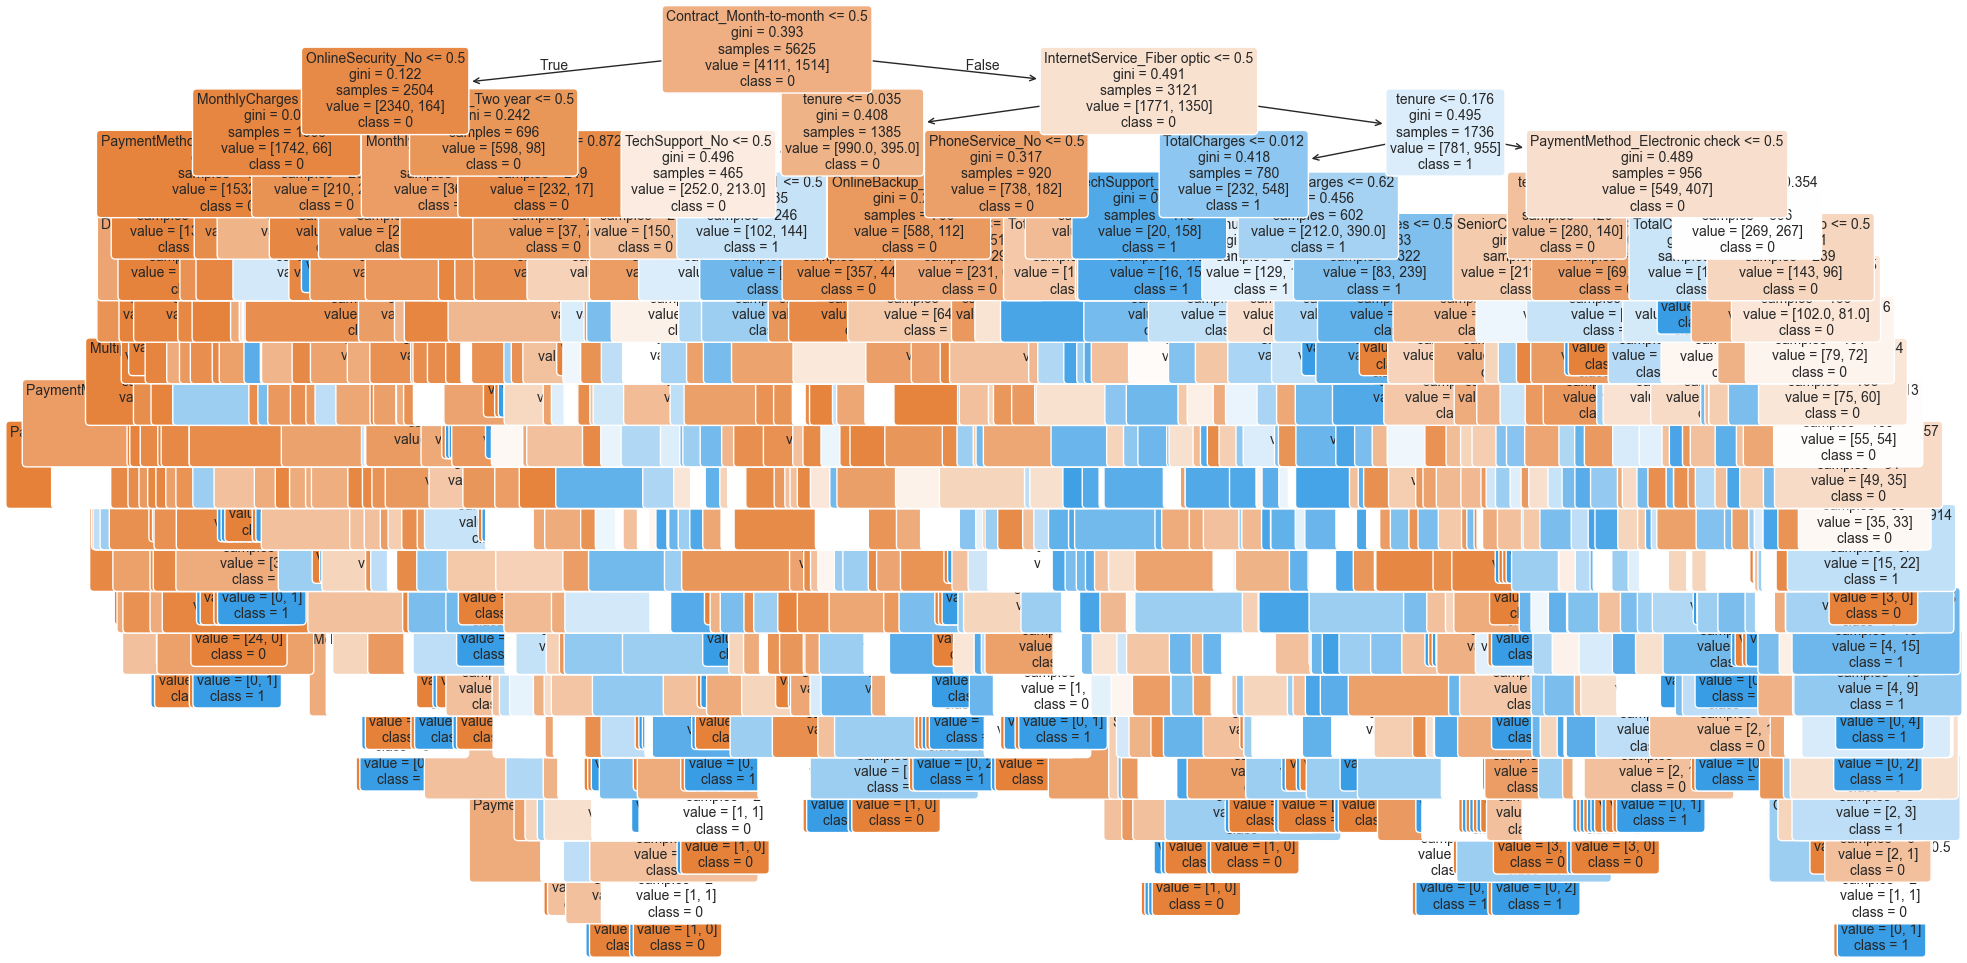

In [77]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    model_dt,
    feature_names=X_train.columns,   # 如果 X_train 是 DataFrame
    class_names=[str(c) for c in model_dt.classes_],  # 類別名稱
    filled=True,       # 顏色填滿，直觀
    rounded=True,      # 圓角
    impurity=True,     # 顯示 gini
    proportion=False,  # 顯示樣本數量
    fontsize=10
)
plt.tight_layout()
plt.show()


Text(0.5, 15.049999999999999, 'Predicted label\n')

<Figure size 2800x2000 with 0 Axes>

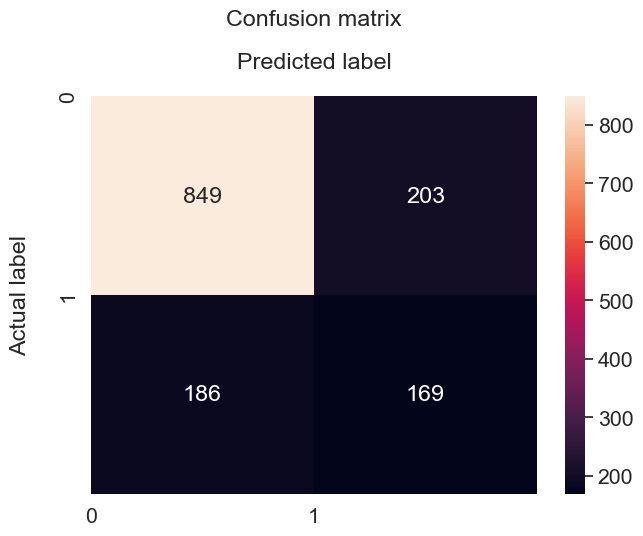

In [76]:
# Create the Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_dt) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))

fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')

class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

In [80]:
TP = 169
FP = 203 
FN=186
TN=849
# TP=180, FP=94, FN=175, TN=958

print(f'Accuracy : {round((TP+TN)/(TN+FN),3)}')    # (TP + TN) / (TP + FP + TN + FN) 
print(f'Precision : {round((TP/(TP+FP)), 3)}')              # TP / (TP + FP)
print(f'Recall/Sensitivity : {round((TP)/(TP+FN), 3)}')     # TP / (TP + FN)
print(f'Specificity : {round((TN)/(TN+FP), 3)}')            # TN / (TN + FP)

Accuracy : 0.984
Precision : 0.454
Recall/Sensitivity : 0.476
Specificity : 0.807


### Decision Tree Optimization - Pruning

In [81]:
preprocessor = make_pipeline(SelectKBest(f_classif, k=10)) # 挑選出K個分數最高的特徵
DecisionTree = make_pipeline(preprocessor,DecisionTreeClassifier(random_state=0))

In [82]:
DecisionTree.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'pipeline', 'decisiontreeclassifier', 'pipeline__memory', 'pipeline__steps', 'pipeline__transform_input', 'pipeline__verbose', 'pipeline__selectkbest', 'pipeline__selectkbest__k', 'pipeline__selectkbest__score_func', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__monotonic_cst', 'decisiontreeclassifier__random_state', 'decisiontreeclassifier__splitter'])

In [95]:
hyper_params_dt = {
    'decisiontreeclassifier__max_leaf_nodes':[10,20,30],    # 最多有多少個leaf nodes
    'decisiontreeclassifier__min_samples_leaf': [5,10,15],  # 要成為leaf nodes，最少需要多少資料
    'decisiontreeclassifier__max_depth': [5,10,15]          # 限制樹的高度最多幾層
}

In [96]:
grid_dt = GridSearchCV(DecisionTree, hyper_params_dt, scoring='recall', cv=3) 
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

{'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_leaf_nodes': 30, 'decisiontreeclassifier__min_samples_leaf': 5}


In [93]:
y_test_pred_griddt = grid_dt.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred_griddt)

0.7953091684434968

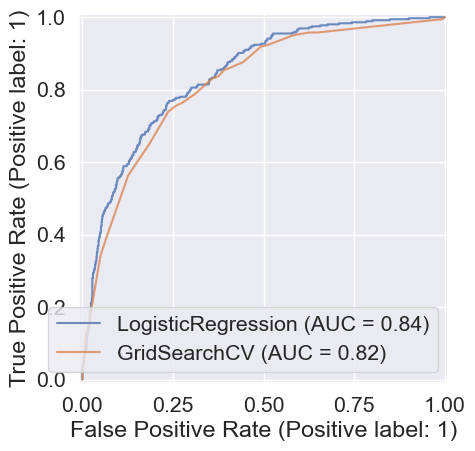

In [94]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
log_disp = RocCurveDisplay.from_estimator(model_log, X_test, y_test, ax=ax, alpha=0.8)
grid_dt_disp = RocCurveDisplay.from_estimator(grid_dt, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

### Visualization

In [86]:
from sklearn import tree
print(tree.export_text(model_dt))

|--- feature_37 <= 0.50
|   |--- feature_19 <= 0.50
|   |   |--- feature_1 <= 0.83
|   |   |   |--- feature_44 <= 0.50
|   |   |   |   |--- feature_2 <= 0.00
|   |   |   |   |   |--- feature_9 <= 0.50
|   |   |   |   |   |   |--- feature_2 <= 0.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_2 >  0.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_9 >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_2 >  0.00
|   |   |   |   |   |--- feature_1 <= 0.49
|   |   |   |   |   |   |--- feature_0 <= 0.82
|   |   |   |   |   |   |   |--- feature_0 <= 0.73
|   |   |   |   |   |   |   |   |--- feature_15 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_5 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_2 <= 0.25
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- feature_2 >  0.25
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|  

In [88]:
!pip3 install six
!pip3 install pydotplus

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24660 sha256=f74f9b00adaf60ef6fd7ef89a61a5b1ffe71963fe82f9cc923cc3b9b8ae774cd
  Stored in directory: c:\users\student\appdata\local\pip\cache\wheels\4a\c0\ed\a9eeeb08c3c53bb90d3822cf76557c8fdcbc349ee11a011169
Successfully built pydotplus


In [ ]:
# http://www.graphviz.org/download/
# InvocationException: GraphViz's executables not found

SyntaxError: unterminated string literal (detected at line 2) (978941098.py, line 2)

In [90]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


dot_data = StringIO()
export_graphviz(model_dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

## 3-4 Random Forest (PPT 2.4)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Make predictions
y_test_pred_rf = model_rf.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_pred_rf))

In [ ]:
# Create the Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_rf) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))

fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')

class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

### <span style="color:#3498DB">Question: 請自行算出下列衡量標準，並與Logistic regression結果比較 </span>

* Accuracy
* Precision
* Recall/Sensitivity
* Specificity

### <span style="color:#3498DB">Question: 何種原因對churn的重要性最高？請與Logistic Regression相互比較 </span>

In [ ]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

### Random Forest Optimization

* n_estimators: int，森林裡樹木的數量，預設為10     
* max_depth: int或None，樹的最大深度，預設為None     
* bootstrap: 是否隨機抽樣，默認為True     
* max_features: 每個決策樹最大的特徵數量，預設為”auto”，max_features = n_features 
* max_leaf_nodes: 通過限制最大葉子節點數，防止過擬合，默認是"None”。如加了限制，會建立在最大葉子節點數內最優的決策樹。如果特徵不多，可以不考慮這個值

In [ ]:
preprocessor = make_pipeline(SelectKBest(f_classif, k=10))
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))

In [ ]:
RandomForest.get_params().keys()

In [ ]:
hyper_params_rf = {"randomforestclassifier__n_estimators":[10,50,100,150,200],
                   "randomforestclassifier__max_depth":[5,10,15,20], 
                   "randomforestclassifier__max_leaf_nodes":[10,20,30]}

In [ ]:
grid_rf = GridSearchCV(RandomForest, hyper_params_rf, scoring='recall', cv=3)
grid_rf.fit(X_train, y_train)
print(grid_rf.best_params_)

In [ ]:
y_test_pred_gridrf = grid_rf.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred_gridrf)

In [ ]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
log_disp = RocCurveDisplay.from_estimator(model_log, X_test, y_test, ax=ax, alpha=0.8)
grid_rf_disp = RocCurveDisplay.from_estimator(grid_rf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

## 3.5 XgBoost (PPT.5)

### 3.5.1 Basic

In [ ]:
from xgboost import XGBClassifier
model_xg = XGBClassifier()
model_xg.fit(X_train, y_train)
y_test_pred_xg = model_xg.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred_xg)

In [ ]:
# Create the Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_xg) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))

fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')

class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

In [ ]:
# TP=178, FP=126, FN=177, TN=926

print(f'Accuracy : {round((178+926)/(178+126+926+177),3)}')    # (TP + TN) / (TP + FP + TN + FN) 
print(f'Precision : {round((178)/(178+126), 3)}')              # TP / (TP + FP)
print(f'Recall/Sensitivity : {round((178)/(178+177), 3)}')     # TP / (TP + FN)
print(f'Specificity : {round((958)/(958+126), 3)}')            # TN / (TN + FP)

In [ ]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
log_disp = RocCurveDisplay.from_estimator(model_log, X_test, y_test, ax=ax, alpha=0.8)
model_xg_disp = RocCurveDisplay.from_estimator(model_xg, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

### 3.5.2 XgBoost Optimization

| 參數                      | 功能說明                      |
| ----------------------- | ------------------------- |
| `n_estimators`          | 樹的數量，太少會欠擬合，太多可能過擬合       |
| `max_depth`             | 樹的最大深度，影響模型複雜度            |
| `learning_rate` (`eta`) | 每棵樹學習貢獻度，太大會過擬合，太小則學習太慢   |
| `subsample`             | 每次訓練用多少比例樣本（避免過擬合）        |
| `colsample_bytree`      | 每棵樹訓練時隨機取多少比例的特徵          |
| `gamma`                 | 最小 loss 減少才允許分裂的閾值（越大越保守） |
| `min_child_weight`      | 控制葉節點最小樣本總權重（防止過擬合）       |

#### 3.5.2.1 GridSearchCV

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(XGBClassifier(), param_grid, scoring='recall', cv=3)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 取得最佳模型
best_model = grid_search.best_estimator_

# 測試集預測
y_pred = best_model.predict(X_test)

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

precision: 預測為流失的客戶中有多少是真正流失的？    
recall: 所有真正流失的客戶中，有多少被成功預測出來？    
f1-score: precision 和 recall 的加權平均（兼顧準確與完整）    

這對流失預測特別重要，recall 通常要特別關注，避免漏掉會流失的客戶。    

* TN（左上）：預測為不流失，實際也不流失（947 人）
* FP（右上）：預測會流失，但實際沒有（105 人，誤殺）
* FN（左下）：預測不會流失，但實際流失了（169 人，漏報 ⚠）
* TP（右下）：預測會流失，實際也流失（186 人）

→ 若 FN 很多，要調高 recall（召回率）！

In [ ]:
TP=186; FP=105; FN=169; TN=947

print(f'Accuracy : {round((TP + TN) / (TP + FP + TN + FN),3)}') 
print(f'Precision : {round(TP / (TP + FP), 3)}')                  
print(f'Recall/Sensitivity : {round(TP / (TP + FN), 3)}')       
print(f'Specificity : {round(TN / (TN + FP), 3)}')

#### 3.5.2.2 RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# 設定參數範圍
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.5),
    'min_child_weight': randint(1, 10)
}

# 執行隨機搜尋: 「用隨機搜尋的方式，從你定義好的參數空間中，試 30 組組合，並用交叉驗證比出誰最好，最後挑出表現最好的 XGBoost 模型。」
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'), # 設定用來衡量模型好壞的內部評估方式，這裡是「對數損失」，常用於分類。
    param_distributions=param_dist,  # 想要隨機試哪些參數組合。
    n_iter=30,         # 總共要嘗試幾組參數組合。這裡是試 30 組，數量愈多愈可能找到最佳，但花的時間也會增加。
    scoring='recall', # 用recall來評估每一組模型的好壞
    cv=3,             # 使用 3 折交叉驗證（Cross-Validation）：把訓練資料分成 3 份，每次用其中兩份訓練、一份驗證，重複三次平均，提升評估準確性。
    verbose=1,       # 讓執行過程有顯示輸出資訊，方便觀察訓練進度。
    random_state=42, # 為了確保每次執行結果一致（可重現），設定隨機種子。
    n_jobs=-1        # 使用電腦上所有核心來加速運算（平行運算），節省訓練時間。
)

random_search.fit(X_train, y_train)

print("最佳參數組合：", random_search.best_params_)
print("交叉驗證最佳準確率：", random_search.best_score_)

In [ ]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("測試集準確率：", acc)

In [ ]:
# 取得最佳模型
best_model2 = random_search.best_estimator_

# 測試集預測
y_pred = best_model2.predict(X_test)

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model2.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

* TN（左上）：預測為不流失，實際也不流失（937 人）
* FP（右上）：預測會流失，但實際沒有（115 人，誤殺）
* FN（左下）：預測不會流失，但實際流失了（163 人，漏報 ⚠）
* TP（右下）：預測會流失，實際也流失（192 人）

In [ ]:
TP=192; FP=115; FN=163; TN=937

print(f'Accuracy : {round((TP + TN) / (TP + FP + TN + FN),3)}') 
print(f'Precision : {round(TP / (TP + FP), 3)}')                  
print(f'Recall/Sensitivity : {round(TP / (TP + FN), 3)}')       
print(f'Specificity : {round(TN / (TN + FP), 3)}')

----------

### <span style="color:#3498DB">Question: 總上四種模型，請問你要選哪個？為何？ </span>